In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [2]:
C =cosmology.Planck15

## First: generate matrix using labels to keep track

In [3]:
statesto = pd.Index(('BD1', 'RD1', 'RE1'))
statesfrom = pd.Index(('BD1', 'RD1'))
for i in range(2,6):
    statesto=statesto.append(pd.Index(('BD%s'%i,'RD%s'%i,'RE%s'%i)))
for i in range(2,4):
    statesfrom=statesfrom.append(pd.Index(('BD%s'%i,'RD%s'%i)))
statesfrom = statesfrom.append(pd.Index(('BD4','RD4','K')))
rate_labels = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom, data=np.chararray((15,9)))
for frm in statesfrom:
    for to in statesto:
        rate_labels['from '+frm]['to '+to] = '$r_{%s \rightarrow %s}$'%(frm,to)


In [4]:
def rate_matrix_labels(rates):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is a vector - m[0] = m1, m[3] = m4
    rate_mtrx = pd.DataFrame(index=np.linspace(1,12,12),columns=np.linspace(1,12,12),data=np.chararray((12,12)))
    for i in range(1,5): #things multiplied by BDN
        rate_mtrx[i][i] = '-' + rates['from BD{}'.format(i)]['to RD{}'.format(i)] + ' -' +rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]+ ' -' +'$a~sSFR(t)$'
    for i in range(1,5):
        rate_mtrx[i][i+4] = rates['from BD{}'.format(i)]['to RD{}'.format(i)]
        rate_mtrx[i+4][i+4] = '-'+rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]
    
    for i in range(1,5):
        rate_mtrx[i+8][i+8] = rates['from K']['to RE{}'.format(i)]
    for i in range(1,4):
        rate_mtrx[i][i+9] = rates['from BD{}'.format(i)]['to RE{}'.format(i+1)] # BD_N -> RE(n+1)
        rate_mtrx[i+4][i+9] = rates['from RD{}'.format(i)]['to RE{}'.format(i+1)] #RD_N -> RE_n+1
    return rate_mtrx


In [5]:
rm = rate_matrix_labels(rate_labels)
rm

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
1,-$r_{BD1 \rightarrow RD1}$ -$r_{BD1 \rightarro...,,p,�,6,,,,H,,p,�
2,6,-$r_{BD2 \rightarrow RD2}$ -$r_{BD2 \rightarro...,,,,A,',�,6,,,
3,P,A,-$r_{BD3 \rightarrow RD3}$ -$r_{BD3 \rightarro...,�,6,,,,�,A,',�
4,6,,,-$r_{BD4 \rightarrow RD4}$ -$r_{BD4 \rightarro...,�,A,',�,6,,,
5,$r_{BD1 \rightarrow RD1}$,B,',�,-$r_{RD1 \rightarrow RE2}$,,,,P,B,',�
6,6,$r_{BD2 \rightarrow RD2}$,,,�,-$r_{RD2 \rightarrow RE3}$,',�,6,,,
7,�,B,$r_{BD3 \rightarrow RD3}$,�,6,,-$r_{RD3 \rightarrow RE4}$,,�,,�,�
8,6,,,$r_{BD4 \rightarrow RD4}$,P,,�,-$r_{RD4 \rightarrow RE5}$,6,,,
9,p,,,,,,,,$r_{K \rightarrow RE1}$,,,
10,$r_{BD1 \rightarrow RE2}$,,,,$r_{RD1 \rightarrow RE2}$,,p,�,6,$r_{K \rightarrow RE2}$,,


## Same thing but with values instead of labels:

In [6]:
rates = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom,data=np.zeros(shape=(15,9)))
for i in range(1,5):
    rates['from BD{}'.format(i)]['to RD{}'.format(i)]=.05
    rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]=.05
    rates['from K']['to RE{}'.format(i)]=.05
    rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]=.05
    
rates

,from BD1,from RD1,from BD2,from RD2,from BD3,from RD3,from BD4,from RD4,from K
to BD1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
to RD1,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
to RE1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05
to BD2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
to RD2,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00
to RE2,0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.05
to BD3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
to RD3,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00
to RE3,0.00,0.00,0.05,0.05,0.00,0.00,0.00,0.00,0.05
to BD4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [7]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is a vector - m[0] = m1, m[3] = m4
    rate_mtrx = pd.DataFrame(index=np.linspace(1,12,12),columns=np.linspace(1,12,12),data=np.zeros((12,12)))
    a_s = -1.4 
    M_star = 10.82

    for i in range(1,5): #things multiplied by BDN
        rate_mtrx[i][i] = -rates['from BD{}'.format(i)]['to RD{}'.format(i)] - rates['from BD{}'.format(i)]['to RE{}'.format(i+1)] + alpha(a_s,M_star,m[i-1])*sSFR(t)
    for i in range(1,5):
        rate_mtrx[i][i+4] = rates['from BD{}'.format(i)]['to RD{}'.format(i)]
        rate_mtrx[i+4][i+4] = -rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]
    
    for i in range(1,5):
        rate_mtrx[i+8][i+8] = rates['from K']['to RE{}'.format(i)]
    for i in range(1,4):
        rate_mtrx[i][i+9] = rates['from BD{}'.format(i)]['to RE{}'.format(i+1)] # BD_N -> RE(n+1)
        rate_mtrx[i+4][i+9] = rates['from RD{}'.format(i)]['to RE{}'.format(i+1)] #RD_N -> RE_n+1
    return rate_mtrx
def model(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


In [8]:
m=[9,10,11,12]
t=C.age(3).value
rate_mtrx=rate_matrix(rates,m,t)
rate_mtrx

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
1,-9.109457,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.000000,-9.785436,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.000000,0.000000,-10.461416,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.000000,0.000000,0.000000,-11.137396,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.050000,0.000000,0.000000,0.000000,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.000000,0.050000,0.000000,0.000000,0.00,-0.05,0.00,0.00,0.00,0.00,0.00,0.00
7,0.000000,0.000000,0.050000,0.000000,0.00,0.00,-0.05,0.00,0.00,0.00,0.00,0.00
8,0.000000,0.000000,0.000000,0.050000,0.00,0.00,0.00,-0.05,0.00,0.00,0.00,0.00
9,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00
10,0.050000,0.000000,0.000000,0.000000,0.05,0.00,0.00,0.00,0.00,0.05,0.00,0.00


## Above: rate matrix properly set up (value positions match the rate_labels matrix above). Yay. 

In [9]:
#centers of bins where f_rid and f_dir are evaluated in the data
z_centers = [0.3125, 0.53750000000000009, 0.76250000000000007, 0.98750000000000004]
z_centers = [round(z,2) for z in z_centers]
#mass bins
m_edges = [10.1,10.4,10.7,11,11.3]
m_centers = [(m_edges[i]+m_edges[i+1])/2. for i in range(0,len(m_edges)-1)]
z_centers,m_centers

#define times/redshifts to compute evolution in model
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value


In [10]:
#load dictionary of data; N_RD, N_BD, N_RE, f_RID, f_DIR evolutions for each mass bin
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)


In [11]:
def model_fractions(rate_vector, m_centers):
    # Set rates per galaxy in Gyr^{-1} at fiducial redshift
    rates = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom,data=np.zeros(shape=(15,9)))
    for i in range(1,5):
        rates['from BD{}'.format(i)]['to RD{}'.format(i)]=rate_vector['BD{} to RD{}'.format(i,i)]
        rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['BD{} to RE{}'.format(i,i+1)]
        rates['from K']['to RE{}'.format(i)]=rate_vector['K to RE{}'.format(i)]
        rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['RD{} to RE{}'.format(i,i+1)]

    #set initial values
    states = pd.Index((('BD1'),('BD2'),('BD3'),('BD4'),('RD1'),('RD2'),('RD3'),('RD4'),('RE1'),('RE2'),('RE3'),('RE4')))
    #inital BD, RD, RE for masses 1-4 (z=1)
    N0=pd.Series(index=states)
    for i, m in enumerate(m_centers):
        N0['BD{}'.format(i+1)] = results['M={}'.format(m)]['N_BD'][3]
        N0['RD{}'.format(i+1)] = results['M={}'.format(m)]['N_RD'][3]
        N0['RE{}'.format(i+1)] = results['M={}'.format(m)]['N_RE'][3]    
    N0 /= N0.sum()  # normalise to unity
        
    #evolve numbers from z=1 to z=0.3
    N = odeint(model, N0, t, args=(rates, rate_matrix, m_centers))
    N = pd.DataFrame(index=z, columns=states, data=N)
    N=N[::-1] #number evolution of BD,RD,RE
    
    F_RD = pd.DataFrame(index=N.index) #evolution of fractions
    F_DR = pd.DataFrame(index=N.index) #evolution of fractions

    for i in range(1,5):
        F_RD['$f_{R|D}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['BD{}'.format(i)])
    for i in range(1,5):
        F_DR['$f_{D|R}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['RE{}'.format(i)])
    
    #compare results of fractions at 3 redshifts, for 2 fractions, for all 4 masses, compute chi-squared:
    chi2 = 0
    
    for m,M in enumerate(m_centers):
        for i,zc in enumerate(z_centers[:-1]): 
            obs_f_rid = results['M={}'.format(M)]['f_RID'][i]
            obs_f_dir = results['M={}'.format(M)]['f_DIR'][i]
            obs_f_rid_err = results['M={}'.format(M)]['f_RID_err'][i]
            obs_f_dir_err = results['M={}'.format(M)]['f_DIR_err'][i]

            idx = find_nearest(z,zc) #find closest redshift to zc in model
            model_f_rid = F_RD['$f_{R|D}\_%s$'%(m+1)][idx]
            model_f_dir = F_DR['$f_{D|R}\_%s$'%(m+1)][idx]
    
            chi2 += ((obs_f_rid - model_f_rid)/obs_f_rid_err)**2
            chi2 += ((obs_f_dir - model_f_dir)/obs_f_dir_err)**2
            #chi2 += (obs_f_rid - model_f_rid)/model_f_rid
            #chi2 += (obs_f_dir - model_f_dir)/model_f_rid

    #all done! return chi square value for these rates
    return F_RD, F_DR, chi2
    #return chi2

In [12]:
def plot_NF(F_RD,F_DR):
    colors = ['#008744','#0c457d','#aa1841','#54235c']
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(12, 6))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, 1));
    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4));
    plt.tight_layout()

In [13]:
#define rate labels
rate_vector_labels = pd.Index((('BD1 to RD1'),('BD2 to RD2'),('BD3 to RD3'), ('BD4 to RD4'),
                            ('BD1 to RE2'), ('BD2 to RE3'), ('BD3 to RE4'), ('BD4 to RE5'),
                              ('RD1 to RE2'), ('RD2 to RE3'), ('RD3 to RE4'), ('RD4 to RE5'),
                              ('K to RE1'), ('K to RE2'), ('K to RE3'), ('K to RE4')))

In [14]:
def rate_list(n, mx):
    #a = bd1 -> rd1
    #b = bd2 -> rd2
    #c = bd3 -> rd3
    #d = bd4 -> rd4
    #e = bd1 -> re2
    #f = bd2 -> re3
    #g = bd3 -> re4
    #h = bd4 -> re5
    #i = rd1 -> re2
    #j = rd2 -> re3
    #k = rd3 -> re4
    #l = rd4 -> re5
    #m = K -> re1 #K's encompass total rate entering/leaving RE1 from RE0 and RE2, so could be + or -
    #o = K -> re2
    #p = K -> re3
    #q = K -> re4
    
    #max rate = +/- 0.1
    #n = number of steps for each rate
    
    rate_data = [[a/n*mx,b/n*mx,c/n*mx,d/n*mx,
                  e/n*mx,f/n*mx,g/n*mx,h/n*mx,
                  i/n*mx,j/n*mx,k/n*mx,l/n*mx,
                  m/n*mx+.01,o/n*mx+.01,p/n*mx+.01,p/n*mx+.01] 
                 for a in range(1,int(n)+1) for b in range(1,int(n)+1) 
                 for c in range(1,int(n)+1) for d in range(1,int(n)+1) 
                for e in range(1,int(n)+1) for f in range(1,int(n)+1) 
                 for g in range(1,int(n)+1) for h in range(1,int(n)+1) 
                 for i in range(1,int(n)+1) for j in range(1,int(n)+1) 
                 for k in range(1,int(n)+1) for l in range(1,int(n)+1) 
                 for m in range(-1,int(n)) for o in range(-1,int(n)) 
                 for p in range(-1,int(n)) for q in range(-1,int(n)) 
             ]
    return rate_data

In [15]:
#generate a bunch of combinations of rates, 2 each, maximum rate of 0.1
rate_data = rate_list(2.,.1)
print 'number of combinations: %s'%len(rate_data)

number of combinations: 331776


In [148]:
#test 30,000 rate combos to start 
chi2=[]
for i,vector in enumerate(rate_data[0:30000]):
    rate_vector = pd.Series(index=rate_vector_labels,data=vector)
    chi2val = model_fractions(rate_vector,m_centers)
    chi2.append(chi2val)
    if i % 10000 ==0:
        print i, chi2val, datetime.datetime.now().strftime('%H:%M:%S.%f')

0 6608.30552839 10:20:02.475400
10000 6567.46107372 11:05:56.164016
20000 6833.49676305 11:52:12.713406


In [153]:
x=np.linspace(0,len(chi2)-1,len(chi2))

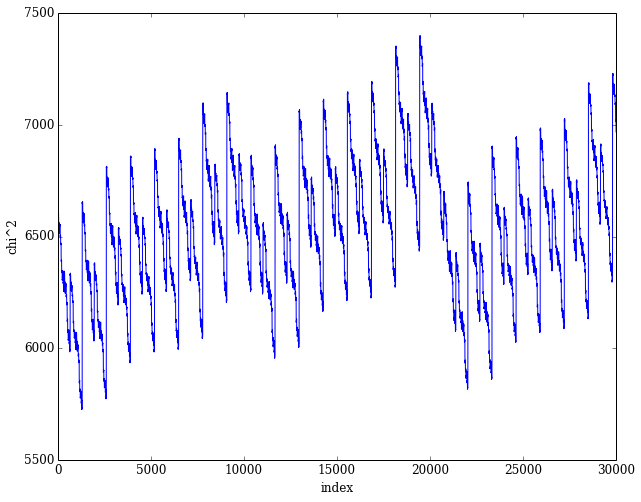

In [155]:
plt.plot(x,chi2)
plt.xlabel('index')
plt.ylabel('chi^2')

In [25]:
#plot current best value
#idx = find_nearest_idx(chi2,np.min(chi2))
rate_vector = pd.Series(index=rate_vector_labels,data=rate_data[1275]) #rate combo with best chi2

In [26]:
F_RD,F_DR,chi2 = model_fractions(rate_vector,m_centers)
chi2

5730.862355219384

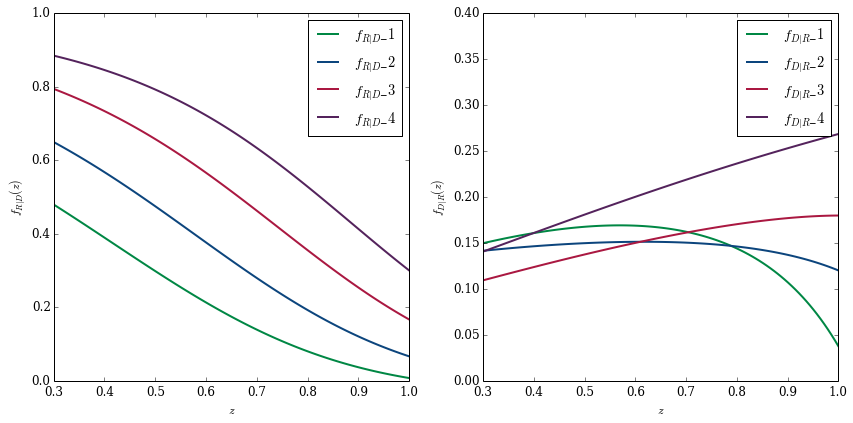

In [27]:
plot_NF(F_RD,F_DR)